## Bootstrap 

In [1]:
from torch.utils.data import DataLoader
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoConfig, PreTrainedModel, AutoModel, AutoProcessor
import torch.nn as nn 
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F
from datasets import load_dataset
from transformers.modeling_outputs import SequenceClassifierOutput
from collections import Counter
import numpy as np
import time
import random
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from dataclasses import dataclass
from typing import List, Dict, Union, List, Any
import matplotlib.pyplot as plt

Для воспроизводимости

In [2]:
torch.set_float32_matmul_precision("high")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Uses device: {device}")

class EmotionClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels=5, dropout=0.2):
        super().__init__()
        self.pool_norm = nn.LayerNorm(hidden_size)
        self.pre_dropout = nn.Dropout(dropout)

        mid1 = max(hidden_size // 2, num_labels * 4)
        mid2 = max(hidden_size // 4, num_labels * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, mid1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid1),
            nn.Linear(mid1, mid2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid2),
            nn.Linear(mid2, num_labels),
        )

    def forward(self, hidden_states, attention_mask=None):
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1, keepdim=True)
            masked = hidden_states * attention_mask.unsqueeze(-1)
            pooled = masked.sum(dim=1) / lengths
        else:
            pooled = hidden_states.mean(dim=1)
        x = self.pool_norm(pooled)
        x = self.pre_dropout(x)
        logits = self.classifier(x)
        return logits

class ModelForEmotionClassification(PreTrainedModel):
    config_class = AutoConfig

    def __init__(
        self, config, model_name, num_labels=5, dropout=0.2
    ):
        super().__init__(config)
        self.encoder = AutoModel.from_pretrained(model_name, trust_remote_code=True).model.encoder
        hidden_size = config.encoder['d_model']
        self.classifier = EmotionClassifier(
            hidden_size, num_labels=num_labels, dropout=dropout
        )
        self.post_init()

    def forward(
        self,
        input_features: torch.Tensor,
        input_lengths: torch.Tensor,
        attention_mask: torch.Tensor = None,
        labels: torch.Tensor = None
    ) -> SequenceClassifierOutput:
        encoded, out_lens = self.encoder(input_features, input_lengths)
        hidden_states = encoded.transpose(1, 2)

        if attention_mask is None:
            max_t = hidden_states.size(1)
            attention_mask = (
                torch.arange(max_t, device=out_lens.device)
                .unsqueeze(0)
                .lt(out_lens.unsqueeze(1))
                .long()
            )

        logits = self.classifier(hidden_states, attention_mask=attention_mask)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)
        
model_name = "nixiieee/gigaam-rnnt-emotion-classifier-dusha"
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
model = ModelForEmotionClassification.from_pretrained(model_name, config=config, model_name=model_name, num_labels=5, dropout=0.05).to(device)

Uses device: cuda:1


Some weights of GigaAMRNNTHF were not initialized from the model checkpoint at nixiieee/gigaam-rnnt-emotion-classifier-dusha and are newly initialized: ['model.encoder.layers.0.conv.batch_norm.bias', 'model.encoder.layers.0.conv.batch_norm.num_batches_tracked', 'model.encoder.layers.0.conv.batch_norm.running_mean', 'model.encoder.layers.0.conv.batch_norm.running_var', 'model.encoder.layers.0.conv.batch_norm.weight', 'model.encoder.layers.0.conv.depthwise_conv.bias', 'model.encoder.layers.0.conv.depthwise_conv.weight', 'model.encoder.layers.0.conv.pointwise_conv1.bias', 'model.encoder.layers.0.conv.pointwise_conv1.weight', 'model.encoder.layers.0.conv.pointwise_conv2.bias', 'model.encoder.layers.0.conv.pointwise_conv2.weight', 'model.encoder.layers.0.feed_forward1.linear1.bias', 'model.encoder.layers.0.feed_forward1.linear1.weight', 'model.encoder.layers.0.feed_forward1.linear2.bias', 'model.encoder.layers.0.feed_forward1.linear2.weight', 'model.encoder.layers.0.feed_forward2.linear1.bi

Загружаем датасет

In [4]:
ds = load_dataset("nixiieee/dusha_balanced", split='test')

Коллакатор и предобработка данных

In [5]:
@dataclass
class DataCollatorForEncoderClassification:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        tensors = [
            f["input_features"]
            if isinstance(f["input_features"], torch.Tensor)
            else torch.tensor(f["input_features"], dtype=torch.float32)
            for f in features
        ]
        seq_lens = [t.shape[0] for t in tensors]
        assert len(set(seq_lens)) == 1, "Все sequences в батче должны быть одинаковой длины"
        batch_inputs = torch.stack(tensors, dim=0)  # shape: [B, T, feat_in]

        batch_labels = torch.tensor(
            [f["labels"] for f in features], dtype=torch.long
        )
        batch_lens = torch.tensor(
            [f["input_lengths"] for f in features], dtype=torch.long
        )

        return {
            "input_features": batch_inputs,
            "input_lengths": batch_lens,
            "labels": batch_labels,
        }


def prepare_dataset(batch):
    audio = batch["audio"]
    processed = processor(
        audio["array"], sampling_rate=audio["sampling_rate"]
    )   
    batch["input_features"] = processed["input_features"][0]
    batch["input_lengths"] = processed["input_lengths"][0]
    batch["labels"] = batch["emotion"]
    return batch


test_ds = ds.map(
    prepare_dataset, remove_columns=["audio", "emotion"],
    num_proc=1
)

data_collator = DataCollatorForEncoderClassification(processor)

Формируем даталоадер

In [6]:
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator
)

In [7]:
model.to(device)
model.eval() # оцениваем качество на валидации

ModelForEmotionClassification(
  (encoder): ConformerEncoder(
    (pre_encode): StridingSubsampling(
      (out): Linear(in_features=12288, out_features=768, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 768, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(768, 768, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
      )
    )
    (pos_enc): RotaryPositionalEmbedding()
    (layers): ModuleList(
      (0-15): 16 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (activation): SiLU()
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm_conv): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (conv): ConformerConvolution(
          (pointwise_conv1): Conv1d(768, 1536, kerne

In [20]:
def get_predictions(model, data_loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch in tqdm(data_loader, desc="Processing all batches"):
            batch = {k: v.to(device) for k, v in x_batch.items()}
            labels = batch['labels'].cpu().numpy()
            all_labels.append(labels)
            outputs = model(input_features=batch['input_features'], input_lengths=batch['input_lengths'])
            logits = outputs.logits
            y_pred = F.softmax(logits, dim=1)
            label_pred = torch.argmax(y_pred, dim=-1)
            all_preds.append(label_pred.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_labels, all_preds

In [21]:
all_labels, all_preds = get_predictions(model, test_loader)

Processing all batches:   0%|          | 0/113 [00:00<?, ?it/s]

In [26]:
def bootstrap_acc(all_labels, all_preds, iteration_list=[1000, 2000, 3000]):
    original_acc = accuracy_score(all_labels, all_preds)
    n_size = len(all_labels)
    
    colors = ['lightblue', 'skyblue', 'navy']
    ci_colors = ['lightblue', 'skyblue', 'navy']
    plt.figure(figsize=(12, 6))
    
    for idx, n_iterations in enumerate(iteration_list):
        acc_scores = []
        
        for i in range(n_iterations):
            indices = np.random.choice(n_size, size=n_size, replace=True)
            bootstrap_labels = all_labels[indices]
            bootstrap_preds = all_preds[indices]
            acc = accuracy_score(bootstrap_labels, bootstrap_preds)
            acc_scores.append(acc)
        mean_acc = np.mean(acc_scores)
        
        lower_ci, upper_ci = np.percentile(acc_scores, [2.5, 97.5])
        
        print(f"\nResults for {n_iterations} iterations:")
        print(f"Mean Accuracy Score: {mean_acc:.4f}")
        print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")
        
        plt.hist(acc_scores, bins=30, alpha=0.3, color=colors[idx], 
                 label=f'{n_iterations} iterations', edgecolor='black')
        
        plt.axvline(lower_ci, color=ci_colors[idx], linestyle='--', 
                    label=f'CI {n_iterations}: [{lower_ci:.4f}, {upper_ci:.4f}]')
        plt.axvline(upper_ci, color=ci_colors[idx], linestyle='--')

        plt.axvline(mean_acc, color=ci_colors[idx], linestyle='-')        
    
    plt.axvline(original_acc, color='blue', linestyle='-', 
                label=f'Original Accuracy: {original_acc:.4f}')
    
    plt.title('Bootstrap Distribution of Accuracy Scores for Different Iterations')
    plt.xlabel('Accuracy Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.8)
    plt.tight_layout()
    plt.show()


Results for 1000 iterations:
Mean Accuracy Score: 0.8156
95% Confidence Interval: [0.8034, 0.8281]

Results for 2000 iterations:
Mean Accuracy Score: 0.8153
95% Confidence Interval: [0.8020, 0.8275]

Results for 3000 iterations:
Mean Accuracy Score: 0.8154
95% Confidence Interval: [0.8026, 0.8287]


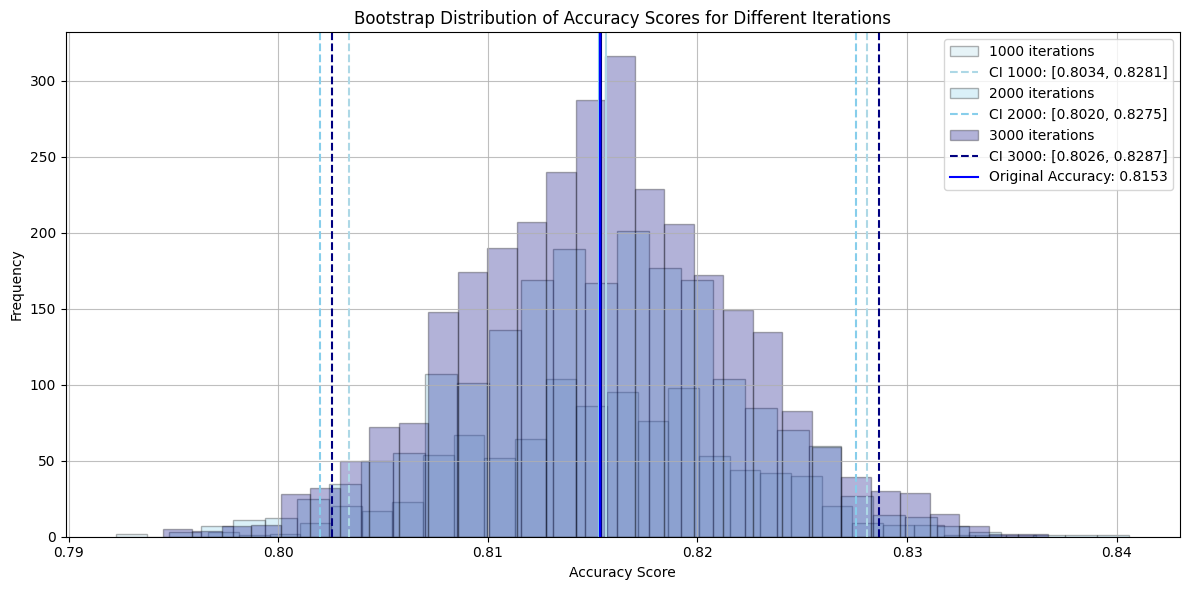

In [27]:
bootstrap_acc(all_labels, all_preds)

In [28]:
def bootstrap_f1(all_labels, all_preds, iteration_list=[1000, 2000, 3000]):
    original_f1 = f1_score(all_labels, all_preds, average="macro")
    n_size = len(all_labels)
    
    colors = ['lightblue', 'skyblue', 'navy']
    ci_colors = ['lightblue', 'skyblue', 'navy'] 
    plt.figure(figsize=(12, 6))
    
    for idx, n_iterations in enumerate(iteration_list):
        f1_scores = []
        
        for i in range(n_iterations):
            indices = np.random.choice(n_size, size=n_size, replace=True)
            bootstrap_labels = all_labels[indices]
            bootstrap_preds = all_preds[indices]
            f1 = f1_score(bootstrap_labels, bootstrap_preds, average="macro")
            f1_scores.append(f1)

        mean_f1 = np.mean(f1_scores)
        lower_ci, upper_ci = np.percentile(f1_scores, [2.5, 97.5])
        
        print(f"\nResults for {n_iterations} iterations:")
        print(f"Mean F1 Score: {mean_f1:.4f}")
        print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")
        
        plt.hist(f1_scores, bins=30, alpha=0.3, color=colors[idx], 
                 label=f'{n_iterations} iterations', edgecolor='black')
        
        plt.axvline(lower_ci, color=ci_colors[idx], linestyle='--', 
                    label=f'CI {n_iterations}: [{lower_ci:.4f}, {upper_ci:.4f}]')
        plt.axvline(upper_ci, color=ci_colors[idx], linestyle='--')
    
    plt.axvline(original_f1, color='blue', linestyle='-', 
                label=f'Original F1: {original_f1:.4f}')
    
    plt.title('Bootstrap Distribution of F1 Scores for Different Iterations')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.8)
    plt.tight_layout()
    plt.show()


Results for 1000 iterations:
Mean F1 Score: 0.8403
95% Confidence Interval: [0.8273, 0.8534]

Results for 2000 iterations:
Mean F1 Score: 0.8400
95% Confidence Interval: [0.8258, 0.8531]

Results for 3000 iterations:
Mean F1 Score: 0.8401
95% Confidence Interval: [0.8266, 0.8530]


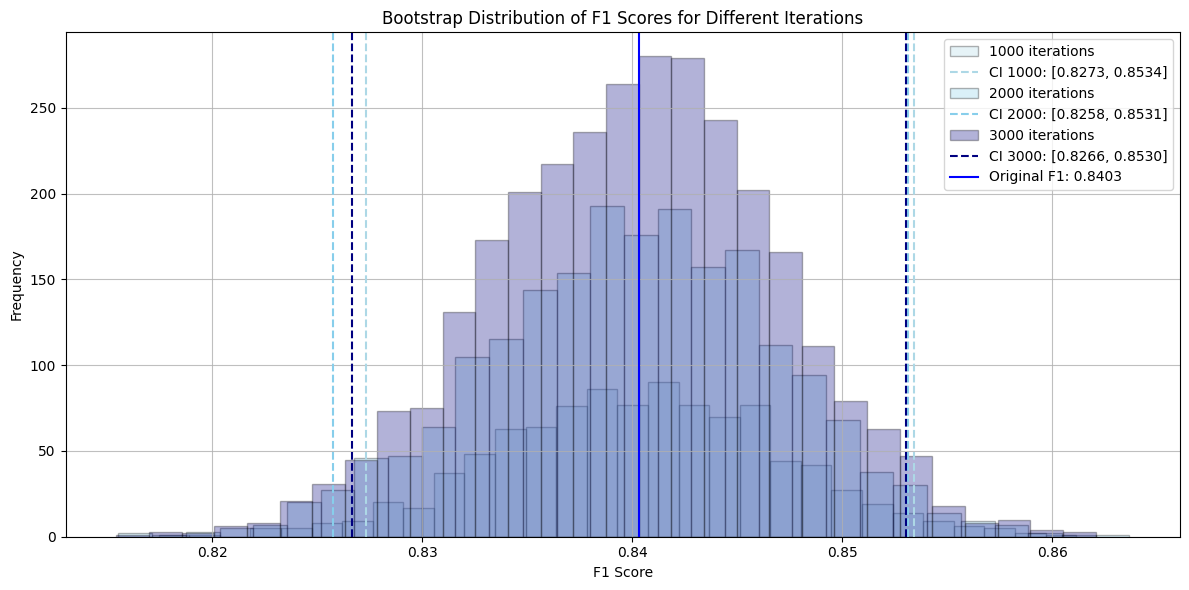

In [29]:
bootstrap_f1(all_labels, all_preds)

In [37]:
from sklearn.metrics import balanced_accuracy_score

def bootstrap_ba(all_labels, all_preds, iteration_list=[1000, 2000, 3000]):
    original_ba = balanced_accuracy_score(all_labels, all_preds)
    n_size = len(all_labels)
    
    colors = ['lightblue', 'skyblue', 'navy']
    ci_colors = ['lightblue', 'skyblue', 'navy'] 
    plt.figure(figsize=(12, 6))
    
    for idx, n_iterations in enumerate(iteration_list):
        ba_scores = []
        
        for i in range(n_iterations):
            indices = np.random.choice(n_size, size=n_size, replace=True)
            bootstrap_labels = all_labels[indices]
            bootstrap_preds = all_preds[indices]
            ba = balanced_accuracy_score(bootstrap_labels, bootstrap_preds)
            ba_scores.append(ba)

        mean_ba = np.mean(ba_scores)
        lower_ci, upper_ci = np.percentile(ba_scores, [2.5, 97.5])
        
        print(f"\nResults for {n_iterations} iterations:")
        print(f"Mean Weighted Accuracy Score: {mean_ba:.4f}")
        print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")
        
        plt.hist(ba_scores, bins=30, alpha=0.3, color=colors[idx], 
                 label=f'{n_iterations} iterations', edgecolor='black')
        
        plt.axvline(lower_ci, color=ci_colors[idx], linestyle='--', 
                    label=f'CI {n_iterations}: [{lower_ci:.4f}, {upper_ci:.4f}]')
        plt.axvline(upper_ci, color=ci_colors[idx], linestyle='--')
    
    plt.axvline(original_ba, color='blue', linestyle='-', 
                label=f'Original Weighted Accuracy: {original_ba:.4f}')
    
    plt.title('Bootstrap Distribution of Weighted Accuracy Scores for Different Iterations')
    plt.xlabel('Weighted Accuracy Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.8)
    plt.tight_layout()
    plt.show()


Results for 1000 iterations:
Mean Weighted Accuracy Score: 0.8370
95% Confidence Interval: [0.8214, 0.8526]

Results for 2000 iterations:
Mean Weighted Accuracy Score: 0.8366
95% Confidence Interval: [0.8202, 0.8522]

Results for 3000 iterations:
Mean Weighted Accuracy Score: 0.8370
95% Confidence Interval: [0.8203, 0.8525]


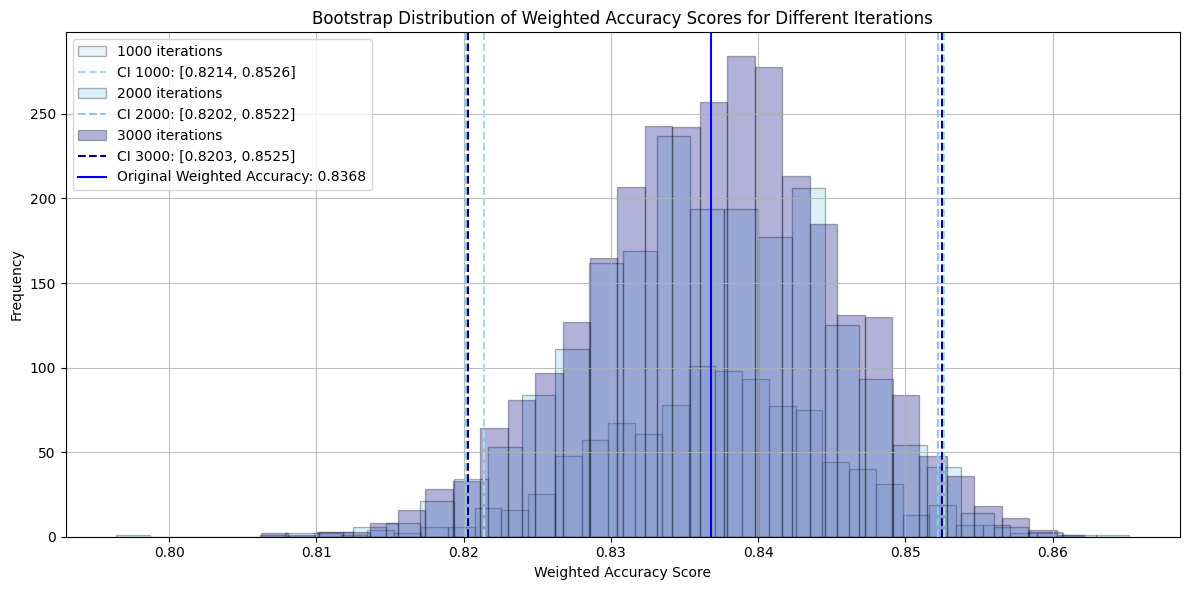

In [38]:
bootstrap_ba(all_labels, all_preds)